In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

from utils import new_labels, new_labels_to_category

# **GTSRB**

German Traffic Sign Recognition Benchmark: In this notebook, I'll train an image classification model using PyTorch. 

For this task I chose the GTSRB dataset provided by the torchvision lybrary.

https://pytorch.org/vision/stable/generated/torchvision.datasets.GTSRB.html#torchvision.datasets.GTSRB

## **Step 1: Exploratory Data Analysis**

TODO:
* Look up the classes
* Plot the distribution
* Fix eventual problems with the data

### **Downloading data** 

In [13]:
transforms = transforms.Compose([
        transforms.Resize([120,120]), # the image are not all equal in size, we need to define a standard size
        transforms.ToTensor() # converts images to torch Tensors and rescales pixels to [0;1] 
    ])

train_dataset = torchvision.datasets.GTSRB(
    root='.',
    split='train',
    transform=transforms,
    download=True
)

test_dataset = torchvision.datasets.GTSRB(
    root='.',
    split='test',
    transform=transforms,
    download=True
)

In [14]:
print(len(train_dataset), len(test_dataset))

26640 12630


### **Data Loader**

In [15]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

### **Visualization**

Image shape: torch.Size([128, 3, 120, 120]), label shape: torch.Size([128])
Min and max pixel values: [0.0, 1.0]
Number of classes 42


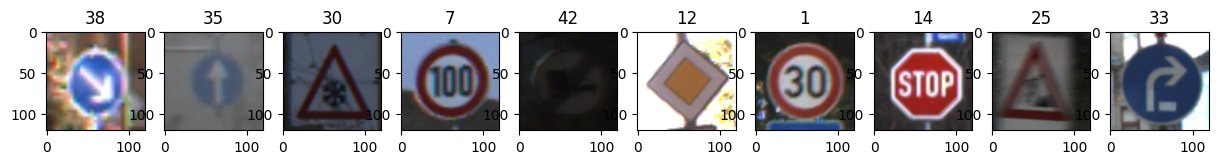

In [16]:
for x, y in train_loader:
    print(f'Image shape: {x.shape}, label shape: {y.shape}')
    print(f'Min and max pixel values: [{torch.min(x)}, {torch.max(x)}]')
    print(f'Number of classes {torch.max(y)}')
    figure, axis = plt.subplots(1, 10, figsize=(15,15))
    for idx in range(10):
        axis[idx].imshow(x[idx].permute(1, 2, 0))
        axis[idx].set_title(y[idx].numpy())
    break

We can see from this first plot that the images are labeled with numbers from 0 to 42, meaning there 43 classes. As a first step, we could try to reduce the number of classes by grouping similar traffic signs together (speed limit, change of direction, ...)

Another thing to see is that images vary largely in contrast, sharpness and quality, it might not be useful to try to augment the data as the difference between images is already really high.

<img src='https://miro.medium.com/max/1100/1*mWK70K4agwvlwR-JBiT-aw.webp' style="background-color:white" width="600" height="500" />

### **Creating new classes** 

In [17]:
assert len(new_labels.keys()) == 43, "Some labels might not have been replaced"

In [18]:
def convert_labels(label_batch):
    """
    input: label_batch (torch.Tensor), a sequence of original labels
    output: (torch.Tensor) a sequence of labels corresponding to the new classes
    """
    assert torch.is_tensor(label_batch), "the input batch sequence is not a torch tensor"
    
    return torch.tensor([new_labels.get(i) for i in y.numpy()])

for x,y in train_loader:
    print(convert_labels(y))
    break

tensor([5, 4, 5, 1, 1, 0, 1, 6, 2, 1, 0, 6, 0, 0, 5, 1, 0, 0, 5, 4, 3, 2, 1, 2,
        0, 0, 4, 2, 5, 6, 1, 0, 5, 1, 1, 1, 1, 0, 2, 2, 5, 2, 0, 4, 0, 0, 1, 5,
        0, 1, 1, 1, 2, 4, 2, 5, 1, 4, 0, 0, 1, 2, 2, 1, 0, 0, 0, 4, 4, 5, 2, 2,
        4, 2, 0, 5, 4, 0, 0, 5, 0, 2, 4, 0, 4, 2, 1, 1, 4, 5, 1, 0, 0, 2, 5, 0,
        1, 1, 2, 0, 0, 1, 1, 4, 5, 1, 1, 5, 0, 4, 5, 0, 2, 0, 0, 0, 0, 4, 0, 5,
        4, 2, 0, 2, 5, 2, 2, 0])


### **Data balancing**

In [8]:
# --- Long computation, commented for performance ---

# full_train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=train_dataset.__len__(),
# )
# for x, y in full_train_loader:
#     original_labels = convert_labels(y)
# fig = px.histogram(original_labels.numpy(), text_auto=True, title="Training samples distribution for the new classes")
# fig.show()

<img src="images\training_distribution.png" />

This graph reveals a slight inbalance in the label distribution we created. The underrepresented classes are "End of limitation" and "Stop" as they refer to few different traffic signs. If the performances on these classes are underwhelming, we can apply class weights in order to bring some balance or use data augmentation to create new samples artificially.

# **Step 2: Modeling**

TODO:
* Define a model architecture
* Define a loss and an optimizer

Output size of convolution and pooling layers :

*   W = input shape
*   F = kernel size
*   P = padding
*   S = Stride
*   D = dilation (always 1 here)

Convolution: $W_{out} = \left \lfloor \frac{W - F + 2P}{S} \right \rfloor +1$

Max pooling: $W_{out} = \left \lfloor \frac{W +2*P - D * (F -1) -1}{S} +1 \right \rfloor$

In [9]:
def conv_arithmetic(input_size:list, kernel_size:list, padding:list, stride:list, type:str):
  """ 
  For type 'conv':
    Returns the output shape of an image after one iteration of "Zero padding, non-unit strides" convolution
    reference: https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html
  For type 'max_pooling':
    Returns the output shape of an image after one ieration of max pooling (2d)
    reference: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
  """
  assert type in ['conv', 'max_pooling'], "invalid type"
  
  match type:
    case 'conv':
      return np.floor(np.divide(input_size + 2*padding[0] - kernel_size[0], stride[0])) + 1
    case 'max_pooling':
      return np.floor(np.divide(input_size +2*padding[1] -1*(kernel_size[1]-1) -1, stride[1]) +1)


def compute_shapes(img_size:int, seq:list):
  for it in range(len(seq)):
    img_size = conv_arithmetic(img_size, kernel_size=[3,2], padding=[1,0], stride=[2,2], type=seq[it])
    print(f'  {it}: {seq[it]} => image size: {img_size}')
  return img_size

In [10]:
print('LeNet inspired model:')
compute_shapes(img_size=120, seq=['conv','max_pooling','conv','max_pooling','conv'])

LeNet inspired model:
  0: conv => image size: 60.0
  1: max_pooling => image size: 30.0
  2: conv => image size: 15.0
  3: max_pooling => image size: 7.0
  4: conv => image size: 4.0


4.0

As a first architecture, I chose to replicate the AlexNet architecture, combining convolutions and max pooling sequentially. 

The previous functions will help us calculate the dimensions of the output image after the Convolution part of the network (PyTorch requires an input dimension for the Linear layers).

Therefore the input shape of the Dense part of the net shall be _**feature_map_dimension * 4 * 4**_, with the feature map dimension being the output dimension of the final convolution.

In [11]:
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()

        self.convolutions = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        self.Dense = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(256*4*4, 1024),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),

            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Linear(512, K)
        )

    def forward(self, x):
        x = self.convolutions(x)
        flat = x.view(x.shape[0], -1)
        x = self.Dense(flat)
        return x

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3473144357.py, line 7)

Now we instantiate the model and define the loss function and optimizer.
* The cross entropy loss is appropriate for a classification problem 
* Adam is a standard choice for an optimize

In [ ]:
model = CNN(43)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In order to make the computation faster, we move the model to the GPU, we will eventually do the same for each training batch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cpu


In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs: int = 10):
    train_losses, test_losses = np.zeros(epochs), np.zeros(epochs)

    for it in range(epochs):  # iterate over epochs

        t0 = datetime.now()
        model.train()
        train_loss = []

        for inputs, targets in train_loader:  # iterate over batches
            inputs, targets = inputs.to(device), targets.to(device)  # convert the targets to the new classes
            optimizer.zero_grad() # reset the optimizer gradient between steps
            
            # forward pass
            outputs = model(inputs)  
            loss = criterion(outputs, targets)

            # backward pass
            loss.backward() # compute the gradient
            optimizer.step() # perform a step of gradient descent

            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)
    
        model.eval()
        test_loss = []

        for inputs, targets in test_loader:  # iterate over batches
            inputs, targets = inputs.to(
                device), targets.to(device)  # convert the targets to the new classes
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        train_losses[it], test_losses[it] = train_loss,  test_loss

        dt = datetime.now() - t0

        print(f'Epoch {it+1} / {epochs}: Train Loss : {train_loss:.4f}, Test Loss : {test_loss:.4f}, duration: {dt}')

    return train_losses, test_losses

In [67]:
# train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, 10)

KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test_loss')
plt.legend()
plt.plot

In [ ]:
def report(loader):
  p_test, y_test = np.array([]), np.array([])
  X_test = []
  model.eval()

  for inputs, targets in loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    X_test.append(inputs)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
    y_test = np.concatenate((y_test, targets.cpu()))

  print(classification_report(y_test, p_test))
  cm = confusion_matrix(y_test, p_test)
  plt.figure(figsize=(15,15))
  sns.heatmap(cm, cmap='Blues', annot=True)
  plt.xlabel('Predicted')
  plt.ylabel('True label')
  plt.show()

  return X_test, p_test, y_test

X_test, p_test, y_test = report(loader=test_loader)

In [ ]:
p_test = p_test.astype(np.uint8)
X_test = test_dataset.data.numpy()
misclassified_idx = np.where(y_test != p_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i].reshape(28,28), cmap='gray')
plt.title(f"True label: {test_dataset.classes[y_test[i]]} / Predicted: {test_dataset.classes[p_test[i]]} ")
plt.show()